In [35]:
import os
import time

import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 12, 8

import uproot

from IPython.display import Image

# FYS5555 2020

## Final Project: ATLAS Open Data

## «Classification of Higgs production mechanism based on Hγγ dataset»



Path from the raw data collected with hardware, sensors and triggers to the high level data, where particles have been identified and particle showers were reconstructed, is long and complicated. Big collaborations like ATLAS and CMS work on reconstructing and matching physics objects from the low level streams of bits. Nowadays, in the era of data, these collaborations give an opportunity to tackle modern particle physics challenges for everyone through pieces of data they share as a part of CERN Open Data initiative.

The aim of this toy project is to learn basic toolkit for data analysis used in CERN, learn structure of ATLAS Open Data (since it quite closely resembles the real data physicists work with), and finally to learn most common pitfalls data analysts in CERN encounter when conducting state of the art analyses.

We will be focusing on the Higgs → γγ dataset. One of the interesting challenges in particle physics that can be implemented with Open Data is to identify the production mechanism of the particle. Knowing various features of the particles, like their number, pt, angular distribution, the goal is to find out whether these particles were produced from Higgs boson born in Vector Boson Fusion process, gluon-gluon fusion, associated production or through emission of top quarks.

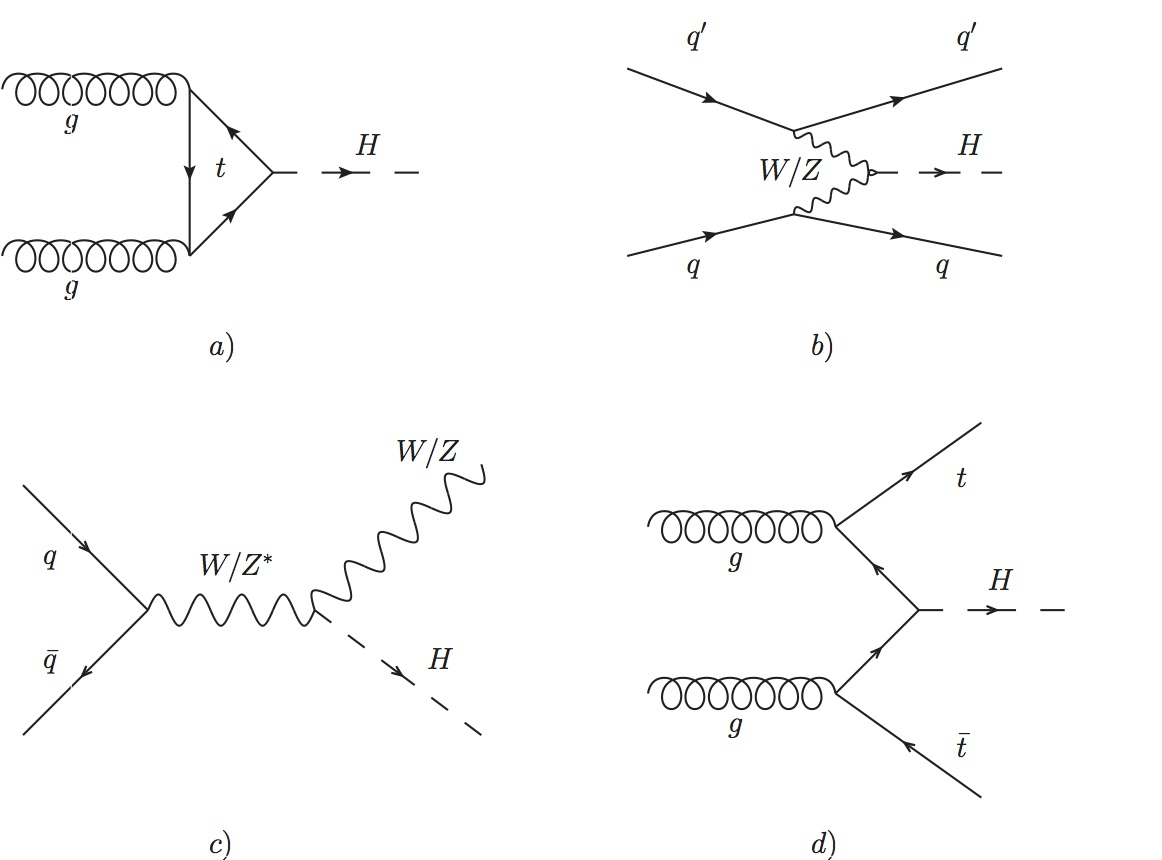

In [2]:
Image("img/higgs_mechanisms.png", width=600)

*(image borrowed from: https://grab-group.ethz.ch/research/higgs-boson.html)*

The outline of the project is as follows:

1. Data investigation. Comparing MC and Data datasets on example of Higgs di-photon peak analysis.
2. Exploratory data analysis. Focusing on MC data, which is labeled, we have a very brief look at the features that will be included or excluded from the feature set required for discrimination of the production mechanisms.
3. Feature processing pipeline. Here we describe how we extract, transform and save features that will be used later for classification.
4. Modelling. The playground of model building. We learn common pitfalls and review possible ways to approach them from the literature.

## Data investigation. Higgs di-photon peak

Event selection based on https://arxiv.org/abs/1802.04146

The goal of this chapter is to practice in extracting data from root files provided by ATLAS OpenData. Fully pythonic approach implemented here could serve as a proof of concept, that flexibility of python zoo of libraries can be exploited fully without loss of the efficiency in data processing.

In [3]:
data_path = "/afs/cern.ch/user/a/ananiev/cernbox/data/"

For the analysis we preserve directory structure from OpenData archives. Monte carlo datasets carry a label that will be useful in the next chapters, where we are going to build classifier for differentiating production mechanisms of the Higgs boson at LHC.

In [4]:
datasets = {
    "GamGam": {
        "Data": [
            "data_A.GamGam",
            "data_B.GamGam",
            "data_C.GamGam",
            "data_D.GamGam"
        ],
        "MC": [
            ("mc_341081.ttH125_gamgam.GamGam", {"tag": "tt"}),
            ("mc_343981.ggH125_gamgam.GamGam", {"tag": "gg"}),
            ("mc_345041.VBFH125_gamgam.GamGam", {"tag": "VBF"}),
            ("mc_345318.WpH125J_Wincl_gamgam.GamGam", {"tag": "Wp"}),
            ("mc_345319.ZH125J_Zincl_gamgam.GamGam", {"tag": "Z"})

        ]
    }
}

In [5]:
def yield_files_with_meta(datasets, type_filter=None):
    if type_filter is None:
        type_filter = ["MC"]
    
    for process_name, process in datasets.items():
        print("Process: ", process_name)
        for type_name, thetype in process.items():
            print("Type: ", type_name)
            if type_name not in type_filter:
                continue
            for filedata in thetype:
                try:
                    filename, meta = filedata
                except ValueError:
                    filename = filedata
                    meta = {}
                print("File: ", filename)
                fullpath = os.path.join("root://", data_path, process_name, type_name, f"{filename}.root")
                yield (process_name, type_name, filename), fullpath

In [6]:
def dict_apply_mask(d, mask, fields=None):
    if fields is None:
        fields = d.keys()
    for f in fields:
        d[f] = d[f][mask]

In [7]:
def eta2tg_theta(eta):
    tg_theta = np.exp(-eta)
    tg_theta = 2*tg_theta/(1 - tg_theta**2)
    return 1/tg_theta

In [8]:
def atlas_two_cosine(events, p1, p2):
    tg_theta_1 = eta2tg_theta(events[p1+b"_eta"])
    tg_theta_2 = eta2tg_theta(events[p2+b"_eta"])
    cos_delta_phi = np.cos(events[p2+b"_phi"] - events[p1+b"_phi"])
    return (cos_delta_phi + tg_theta_1*tg_theta_2)

We see the event features to be grouped into the categories:

* generic features: MET, triggers. weight...
* particle related features: `photon_*`, `lep_*`, `jet_*`, ...

Also we separate features in micro and macro features. Macro features are event wide and can be operated in a vectorized manner through the batch of events, while micro features depend on the particle content within the event. For instance, `photon_n` is a macro feature, each event has some number of photons, and `photon_pt` is a micro feature, because each of the `n` photons in the event has its own `pt`. At the same time, `photon_lead1_pt` is a `pt` for the leading photon, so it becomes "macro" again.

In the function below we apply cuts on event batch based on photon macro and micro features. Notice that there are no explicit loops over events in the batch, that is the power of numpy, that all the loops happen on the backend, powered by c++/fortran precompiled modules.

In [9]:
def photon_filter(events):
    # macro_mask = True
    
    macro_events = {}
    micro_events = {}
    
    macro_events[b"photon_n"] = events[b"photon_n"]
    n_threshold = macro_events[b"photon_n"] >= 2
    macro_mask = n_threshold
    
    micro_events[b"photon_pt"] = events[b"photon_pt"][n_threshold]
    micro_events[b"photon_eta"] = events[b"photon_eta"][n_threshold]
    micro_events[b"photon_phi"] = events[b"photon_phi"][n_threshold]
    micro_events[b"photon_E"] = events[b"photon_E"][n_threshold]
    micro_events[b"photon_isTightID"] = events[b"photon_isTightID"][n_threshold]
    micro_events[b"photon_trigMatched"] = events[b"photon_trigMatched"][n_threshold]
    micro_events[b"photon_ptcone30"] = events[b"photon_ptcone30"][n_threshold]
    micro_events[b"photon_etcone20"] = events[b"photon_etcone20"][n_threshold]
    
    
    pts = micro_events[b"photon_pt"].argsort(ascending=False)
    row_indices = np.arange(pts.shape[0])
    lead_pts = pts[:, 0]
    sublead_pts = pts[:, 1]
    
    
    macro_events[b"photon_n"] = macro_events[b"photon_n"][n_threshold]
    macro_events[b"photon_lead_pt"] = micro_events[b"photon_pt"][row_indices, lead_pts]
    macro_events[b"photon_lead_eta"] = micro_events[b"photon_eta"][row_indices, lead_pts]
    macro_events[b"photon_lead_phi"] = micro_events[b"photon_phi"][row_indices, lead_pts]
    macro_events[b"photon_lead_E"] = micro_events[b"photon_E"][row_indices, lead_pts]
    macro_events[b"photon_lead_isTightID"] = micro_events[b"photon_isTightID"][row_indices, lead_pts]
    macro_events[b"photon_lead_trigMatched"] = micro_events[b"photon_trigMatched"][row_indices, lead_pts]
    macro_events[b"photon_lead_ptcone30"] = micro_events[b"photon_ptcone30"][row_indices, lead_pts]
    macro_events[b"photon_lead_etcone20"] = micro_events[b"photon_etcone20"][row_indices, lead_pts]
    macro_events[b"photon_sublead_pt"] = micro_events[b"photon_pt"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_eta"] = micro_events[b"photon_eta"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_phi"] = micro_events[b"photon_phi"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_E"] = micro_events[b"photon_E"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_isTightID"] = micro_events[b"photon_isTightID"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_trigMatched"] = micro_events[b"photon_trigMatched"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_ptcone30"] = micro_events[b"photon_ptcone30"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_etcone20"] = micro_events[b"photon_etcone20"][row_indices, sublead_pts]
    
    macro_filter = (  (macro_events[b"photon_lead_pt"] > 35000)
                    &
                      (macro_events[b"photon_sublead_pt"] > 25000)
                    &
                      (macro_events[b"photon_lead_isTightID"])
                    &
                      (macro_events[b"photon_sublead_isTightID"])
                    &
                      (macro_events[b"photon_lead_trigMatched"])
                    &
                      (macro_events[b"photon_sublead_trigMatched"])
                    & 
                      (macro_events[b"photon_lead_ptcone30"] < 0.065)
                    & 
                      (macro_events[b"photon_lead_etcone20"] < 0.065)
                    & 
                      (macro_events[b"photon_sublead_ptcone30"] < 0.065)
                    & 
                      (macro_events[b"photon_sublead_etcone20"] < 0.065)
                    & 
                      (  (np.absolute(macro_events[b"photon_lead_eta"]) < 1.37) 
                       | 
                         (  (np.absolute(macro_events[b"photon_lead_eta"]) > 1.52)
                          & (np.absolute(macro_events[b"photon_lead_eta"]) < 2.37)
                         )
                      )
                    & (  (np.absolute(macro_events[b"photon_sublead_eta"]) < 1.37) 
                       | 
                         (  (np.absolute(macro_events[b"photon_sublead_eta"]) > 1.52)
                          & (np.absolute(macro_events[b"photon_sublead_eta"]) < 2.37)
                         )
                      )
                   )
    
    dict_apply_mask(macro_events, macro_filter)
    macro_mask[macro_mask] = macro_filter

    macro_events[b"h_mass"] = np.sqrt(2.*(
                                            macro_events[b"photon_lead_E"]*macro_events[b"photon_sublead_E"] \
                                            - macro_events[b"photon_lead_pt"]*macro_events[b"photon_sublead_pt"]*atlas_two_cosine(macro_events, b"photon_lead", b"photon_sublead")
                                        )
                                     )
    
    mass_cutoff =   (macro_events[b"photon_lead_pt"]/macro_events[b"h_mass"] > 0.35) \
                  & (macro_events[b"photon_sublead_pt"]/macro_events[b"h_mass"] > 0.25) \
                  & (macro_events[b"h_mass"] >= 105000.) \
                  & (macro_events[b"h_mass"] <= 160000)
    
    dict_apply_mask(macro_events, mass_cutoff)
    macro_mask[macro_mask] = mass_cutoff
    
    return macro_events, macro_mask
#photon_filter(test_events)

In addition to photon features, that are relevant for computing the Higgs boson mass, we also compute weights. We normalize weights to luminosity $1~pb^{-1}$, and rescale it later to the proper ATLAS OpenData luminosity.

In [10]:
def process_event_batch(events, bin_edges, weighted=False):
    filtered_photons, photon_macro_mask = photon_filter(events)
    h_masses = filtered_photons[b"h_mass"]/1000
    if weighted:
        total_weights = events[b"SumWeights"][0]
        x_section = events[b"XSection"][0]
        weights = (  events[b"mcWeight"]
                   * events[b'scaleFactor_PILEUP'] 
                   * events[b'scaleFactor_ELE'] 
                   * events[b'scaleFactor_MUON'] 
                   * events[b'scaleFactor_PHOTON'] 
                   * events[b'scaleFactor_TAU'] 
                   * events[b'scaleFactor_BTAG'] 
                   * events[b'scaleFactor_LepTRIGGER'] 
                   * events[b'scaleFactor_PhotonTRIGGER']
                  )[photon_macro_mask]/total_weights*x_section
    else:
        weights = None
    hist = np.histogram(h_masses, bin_edges, weights=weights, density=False)[0]
    return hist
#process_event_batch(test_events, bin_edges)

We are going to fill in the histogram between `105 GeV` and `160 GeV` with a binsize `1 GeV`.

In [11]:
bin_edges = np.linspace(105., 160., 55, dtype=np.float64)

In [12]:
def histogram_per_file(datasets, binedges, type_filter):
    entrysteps = 100000
    
    histograms = {}
    for (process, thetype, name), fullpath in yield_files_with_meta(datasets, type_filter):
        label = f"{process}:{thetype}:{name}"
        histograms[label] = np.zeros((bin_edges.shape[0] - 1,), dtype=np.float64)
        thehist = histograms[label]
        is_mc = ("mc" == thetype.lower())
        with uproot.open(fullpath) as f:
            total_events = f["mini"].numentries
            print("Total Num Events: ", total_events)
            time_start = time.perf_counter()
            time_now = time_start
            times = []
            for i, events in enumerate(f["mini"].iterate(["*"], entrysteps=entrysteps)):
                thehist += process_event_batch(events, bin_edges, weighted=is_mc)
                time_diff = time.perf_counter() - time_now
                time_now += time_diff
                times.append(time_diff)
                print("Processed: ", (i+1)*entrysteps, "; Time per batch: ", time_diff)
            print("Total time: ", time.perf_counter() - time_start, "; Median time per batch: ", np.median(times))
    return histograms

In [13]:
mc_hists = histogram_per_file(datasets, bin_edges, ["MC"])

Process:  GamGam
Type:  Data
Type:  MC
File:  mc_341081.ttH125_gamgam.GamGam
Total Num Events:  576491
Processed:  100000 ; Time per batch:  3.273832584032789
Processed:  200000 ; Time per batch:  2.0901889570523053
Processed:  300000 ; Time per batch:  2.019922111881897
Processed:  400000 ; Time per batch:  2.5594259831123054
Processed:  500000 ; Time per batch:  8.562512199860066
Processed:  600000 ; Time per batch:  1.3569668761920184
Total time:  19.86416905093938 ; Median time per batch:  2.3248074700823054
File:  mc_343981.ggH125_gamgam.GamGam
Total Num Events:  1054711
Processed:  100000 ; Time per batch:  3.693176604108885
Processed:  200000 ; Time per batch:  2.2428605949971825
Processed:  300000 ; Time per batch:  1.3741464968770742
Processed:  400000 ; Time per batch:  2.1243397961370647
Processed:  500000 ; Time per batch:  2.37794060097076
Processed:  600000 ; Time per batch:  1.3524941429495811
Processed:  700000 ; Time per batch:  2.2173393280245364
Processed:  800000 ; 

In [14]:
data_hists = histogram_per_file(datasets, bin_edges, ["Data"])

Process:  GamGam
Type:  Data
File:  data_A.GamGam
Total Num Events:  430344
Processed:  100000 ; Time per batch:  2.957507056882605
Processed:  200000 ; Time per batch:  2.4960478220600635
Processed:  300000 ; Time per batch:  2.146462333854288
Processed:  400000 ; Time per batch:  1.2710055720526725
Processed:  500000 ; Time per batch:  0.6249831181485206
Total time:  9.49666281696409 ; Median time per batch:  2.146462333854288
File:  data_B.GamGam
Total Num Events:  1528717
Processed:  100000 ; Time per batch:  4.2246646550484
Processed:  200000 ; Time per batch:  3.630030795931816
Processed:  300000 ; Time per batch:  1.3716805521398783
Processed:  400000 ; Time per batch:  2.122378665022552
Processed:  500000 ; Time per batch:  2.7519458308815956
Processed:  600000 ; Time per batch:  1.6718853670172393
Processed:  700000 ; Time per batch:  2.113810244947672
Processed:  800000 ; Time per batch:  2.370707865105942
Processed:  900000 ; Time per batch:  1.3582110649440438
Processed:  1

A nice observation, 100 000 events can be processed in 2 seconds. ~4 million events take 2 minutes to process. We could improve by increasing batch size because the major overhead is coming from data transport through xrootd. Moreover multithreading can be applied since analyses of batches are independent.

Below we show histograms collected per file with higgs mass at luminosity $1~pb^{-1}$. Then we add up all the data events to plot them later as data points, and we add up mc events to plot them on the same figure. Before plotting we show aggregated histograms rescaled to the proper luminosity.

In [15]:
mc_hists

{'GamGam:MC:mc_341081.ttH125_gamgam.GamGam': array([ 5.21269920e-12,  6.56134782e-12,  1.01628289e-11,  8.37056639e-12,
         2.35711225e-11,  6.29098509e-12,  0.00000000e+00,  2.31103717e-11,
         4.06991394e-11,  5.46314057e-11,  3.66656636e-11,  1.73526023e-10,
         4.69358986e-10,  9.49041068e-10,  2.25394389e-09,  4.67781192e-09,
         9.46759715e-09,  1.61016687e-08,  2.49771261e-08,  3.06442187e-08,
         2.77014545e-08,  1.99048618e-08,  1.16149170e-08,  6.14027229e-09,
         3.18150128e-09,  1.42953915e-09,  7.46313233e-10,  3.78136633e-10,
         1.66460623e-10,  3.96855881e-11,  5.87530025e-11,  3.27577965e-11,
         2.69526623e-11,  1.51612056e-11,  1.60120806e-11,  3.51363383e-12,
         0.00000000e+00,  8.84092799e-12, -1.67155179e-12,  7.27951033e-12,
         6.45172804e-12,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -6.55653309e-12,  1.42037493e-11,  2.72493139e-12,  0.00000000e+00,
         0.00000000e+00,  6.51745324e-12,  4

In [16]:
data_hists

{'GamGam:Data:data_A.GamGam': array([22., 24., 15., 13., 14., 17., 20., 15., 12., 13.,  7.,  7., 11.,
        18., 13., 11., 12., 12., 15., 11.,  9., 12.,  7.,  4.,  8., 10.,
         7., 14.,  8., 13.,  5.,  6.,  6.,  8.,  7.,  8.,  5.,  5.,  6.,
         8.,  5.,  5.,  8.,  8.,  7.,  6., 10.,  8.,  6.,  3.,  3.,  3.,
         5.,  1.]),
 'GamGam:Data:data_B.GamGam': array([84., 71., 59., 80., 65., 64., 73., 52., 53., 54., 48., 39., 51.,
        63., 32., 45., 38., 51., 51., 45., 40., 44., 30., 28., 35., 39.,
        31., 35., 28., 29., 42., 32., 23., 23., 33., 27., 23., 24., 22.,
        24., 19., 15., 19., 18., 17., 19., 17., 16., 17., 15., 15., 17.,
        11., 14.]),
 'GamGam:Data:data_C.GamGam': array([115., 123., 114.,  76.,  93.,  97.,  70.,  89.,  92.,  88.,  78.,
         81.,  93.,  64.,  61.,  90.,  62.,  54.,  58.,  60.,  62.,  47.,
         56.,  59.,  48.,  42.,  58.,  42.,  58.,  37.,  44.,  31.,  31.,
         33.,  46.,  35.,  33.,  28.,  29.,  28.,  28.,  23.,  38.,

In [17]:
data_hist = sum(data_hists.values())

In [18]:
mc_hist = sum(mc_hists.values())

In [19]:
mc_hist.sum()

0.006633042292767413

In [20]:
data_hist.sum()

9985.0

In [21]:
bin_mid = (bin_edges[1:] + bin_edges[:-1])/2
bin_size = (bin_edges[1:] - bin_edges[:-1])

We also define luminosity as $10.6~fb^{-1}$.

In [22]:
L = 1000*10.6

In [23]:
mc_hist

array([ 8.43514183e-08,  8.43507019e-08,  3.28621601e-07,  1.30637231e-07,
        1.50498417e-07,  2.62837695e-07,  3.03653069e-07,  8.33247822e-07,
        9.28387645e-07,  1.40815936e-06,  3.33098834e-06,  8.63537449e-06,
        1.85798370e-05,  4.14119658e-05,  1.01452568e-04,  2.08742609e-04,
        4.05045080e-04,  6.92393804e-04,  1.01204429e-03,  1.21243621e-03,
        1.09503283e-03,  8.18722488e-04,  4.88938638e-04,  2.66967575e-04,
        1.38687550e-04,  6.55433849e-05,  2.75652261e-05,  1.25741506e-05,
        5.46395588e-06,  2.02198647e-06,  1.01422538e-06,  7.52746034e-07,
        7.66209585e-08,  3.13568917e-07,  2.91330803e-07,  1.80359951e-07,
        5.02950570e-08,  3.72399160e-08,  2.28884911e-08,  6.51198562e-09,
        7.05868786e-08,  7.43093551e-08, -1.01235855e-08,  2.23008101e-09,
       -6.55653309e-12,  1.42037493e-11,  2.72493139e-12,  2.05545803e-08,
        0.00000000e+00,  6.51745324e-12,  4.20641300e-12,  1.01537267e-08,
        1.37806637e-08,  

In [24]:
data_hist

array([393., 379., 361., 342., 324., 326., 301., 298., 300., 272., 272.,
       259., 266., 260., 220., 274., 198., 220., 228., 215., 196., 196.,
       176., 187., 185., 170., 173., 176., 160., 142., 176., 136., 115.,
       126., 157., 129., 128., 115., 118., 111.,  87., 106., 106., 114.,
       101.,  86.,  85.,  80.,  85.,  81.,  65.,  76.,  66.,  67.])

Finally we arrive to the plot with mass of Higgs boson computed from Higgs di-photon events and also datapoints. It turns out that most of the contribution to the data statistics constitute the background, but in MC data we have only signal datasets. That is why data does not match MC properly. Since the goal of this notebook was not the re-discovery of the Higgs, but acquaintance with data, features and relevant python libraries, we are going to wrap up here and follow to the next chapter. There we are going to make use of the workflow we've learned in this chapter and set up the feature processing pipeline for the production mechanism classification problem.

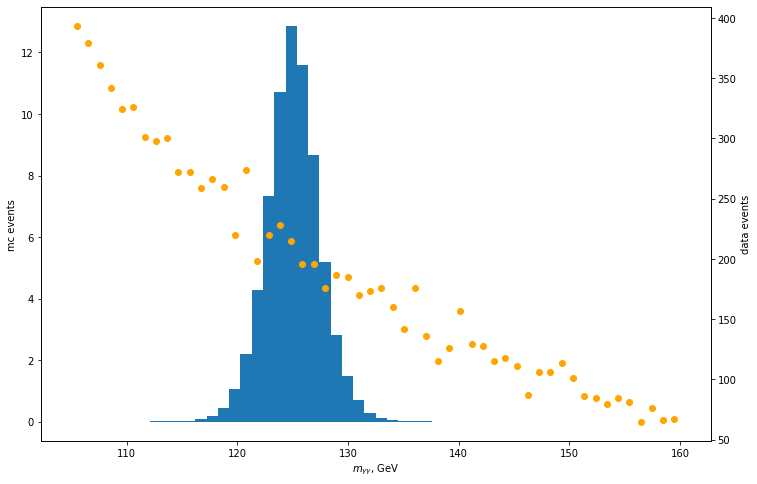

In [37]:
def plot_dat(ax, data_hist, mc_hist):
    ax.bar(bin_mid, mc_hist, width=bin_size, zorder=0)
    ax.set_ylabel("mc events")
    ax1 = ax.twinx()
    ax1.scatter(bin_mid, data_hist, zorder=1, color="orange")
    ax1.set_ylabel("data events")
    ax.set_xlabel("$m_{\gamma \gamma}$, GeV")
fig, ax = plt.subplots()
plot_dat(ax, data_hist, mc_hist*L)
fig.savefig("output/higgs_bump.png")

In [26]:
test_mc = uproot.open(os.path.join("root://", data_path, "GamGam", "MC", f"{datasets['GamGam']['MC'][0][0]}.root"))

In [27]:
test_data = uproot.open(os.path.join("root://", data_path, "GamGam", "Data", f"{datasets['GamGam']['Data'][0]}.root"))

In [28]:
test_data["mini"].keys()

[b'runNumber',
 b'eventNumber',
 b'channelNumber',
 b'mcWeight',
 b'scaleFactor_PILEUP',
 b'scaleFactor_ELE',
 b'scaleFactor_MUON',
 b'scaleFactor_PHOTON',
 b'scaleFactor_TAU',
 b'scaleFactor_BTAG',
 b'scaleFactor_LepTRIGGER',
 b'scaleFactor_PhotonTRIGGER',
 b'trigE',
 b'trigM',
 b'trigP',
 b'lep_n',
 b'lep_truthMatched',
 b'lep_trigMatched',
 b'lep_pt',
 b'lep_eta',
 b'lep_phi',
 b'lep_E',
 b'lep_z0',
 b'lep_charge',
 b'lep_type',
 b'lep_isTightID',
 b'lep_ptcone30',
 b'lep_etcone20',
 b'lep_trackd0pvunbiased',
 b'lep_tracksigd0pvunbiased',
 b'met_et',
 b'met_phi',
 b'jet_n',
 b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_E',
 b'jet_jvt',
 b'jet_trueflav',
 b'jet_truthMatched',
 b'jet_MV2c10',
 b'photon_n',
 b'photon_truthMatched',
 b'photon_trigMatched',
 b'photon_pt',
 b'photon_eta',
 b'photon_phi',
 b'photon_E',
 b'photon_isTightID',
 b'photon_ptcone30',
 b'photon_etcone20',
 b'photon_convType',
 b'tau_n',
 b'tau_pt',
 b'tau_eta',
 b'tau_phi',
 b'tau_E',
 b'tau_isTightID',
 b'tau_tru

In [29]:
test_mc_events = next(test_mc["mini"].iterate(entrysteps=10000))

In [30]:
        total_weights = test_mc_events[b"SumWeights"][0]
        x_section = test_mc_events[b"XSection"][0]
        weights = (  test_mc_events[b"mcWeight"]
                   * test_mc_events[b'scaleFactor_PILEUP'] 
                   * test_mc_events[b'scaleFactor_ELE'] 
                   * test_mc_events[b'scaleFactor_MUON'] 
                   * test_mc_events[b'scaleFactor_PHOTON'] 
                   * test_mc_events[b'scaleFactor_TAU'] 
                   * test_mc_events[b'scaleFactor_BTAG'] 
                   * test_mc_events[b'scaleFactor_LepTRIGGER'] 
                   * test_mc_events[b'scaleFactor_PhotonTRIGGER']
                  )/total_weights*x_section
        weights

array([-4.1094459e-12, -3.5343677e-12, -4.1031982e-12, ...,
       -1.8202724e-12, -3.4606558e-12,  2.8924742e-12], dtype=float32)

In [31]:
test_mc_events[b"XSection"][0]

2.6433863e-06

In [32]:
test_mc_events[b"SumWeights"][0]

485440.0

In [33]:
test_mc_events[b"photon_pt"][:, 0]

array([ 65113.242,  95446.81 , 110997.56 , ..., 126605.32 ,  82455.664,
        81706.914], dtype=float32)

In [34]:
test_mc_events[b"photon_E"][:, 0]*eta2tg_theta(test_mc_events[b"photon_eta"][:, 0])/np.sqrt(eta2tg_theta(test_mc_events[b"photon_eta"][:, 0])**2 + 1)

array([  30832.992, -126962.12 ,    7393.596, ...,   51295.094,
         25653.062,  -18313.086], dtype=float32)